Выполнить классификацию ттвитов из предоставленного набора данных с использованием рекурентных нейронных сетей по 4 классам.
При работе использовать пример example_attenchion.ipnyb  

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import models
from keras import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.metrics import AUC
from keras.regularizers import L1
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup 
import re
import string
import emoji
from sklearn.preprocessing import LabelEncoder

#максимальное количество слов в твите
TEXT_MAX_LEN = 128
#количество наиболее часто используемых слов
TEXT_MAX_WORDS = 27000
RANDOM_STATE = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
colnames=['ID', 'Social network', 'Sentiment', 'Text'] 

df_train = pd.read_csv('twitter_training.csv', names=colnames, header=None)

df_val = pd.read_csv('twitter_validation.csv', names=colnames, header=None)

df_train['Text'] = df_train['Text'].astype(str)
df_val['Text'] = df_val['Text'].astype(str)

Объявляем функцию для очистки датасетов

In [3]:
STOPWORDS = stopwords.words("english")
STOPWORDS.remove('not')
STOPWORDS.remove('no')

def clean_data(tweet):
    #приводим к нижнему регистру
    tweet = tweet.lower() 
    #убираем значение <unk>, которое встречается в некоторых строках
    tweet = tweet.replace("<unk>", "")
    #убираем ссылки, знаки препинания и прочие символы
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet) 
    tweet = ''.join (c for c in tweet if c not in string.digits)  #убираем все символы, которые относятся к цифрам
    #убираем эмодзи, знаки пунктуации и стоп-слова
    tweet = ' '.join(c for c in tweet.split() if emoji.is_emoji(c)==False  
                                    and c not in string.punctuation 
                                    and c not in STOPWORDS)
    tweet = tweet.replace("#", "").replace("_", " ").replace("pm","") 
    return tweet

In [4]:
df_train['Cleaned_Text'] = df_train['Text'].apply(lambda x:clean_data(x))
df_val['Cleaned_Text'] = df_val['Text'].apply(lambda x:clean_data(x))

In [5]:
labeles = LabelEncoder()
train_labels = to_categorical(labeles.fit_transform(df_train['Sentiment']), num_classes=4)
test_labels = to_categorical(labeles.transform(df_val['Sentiment']), num_classes=4)

In [6]:
tokenizer = Tokenizer (num_words=20000,
                       lower = True,
                       split = ' ',
                       char_level=False)
tokenizer.fit_on_texts(df_train['Cleaned_Text'])

data = tokenizer.texts_to_sequences(df_train['Cleaned_Text'])
data_pad = pad_sequences (data, maxlen=TEXT_MAX_LEN)

In [7]:
#перемешиваем данные
indices = np.arange(data_pad.shape[0])    # перемешиваем данные
np.random.shuffle(indices)
X = data_pad[indices]
y = train_labels[indices]

#делаем тренировочную и валидационную выборки
X_train = X[:60000]; X_val = X[60000:]
y_train = y[:60000]; y_val = y[60000:]

In [8]:
data_test = tokenizer.texts_to_sequences(df_val['Cleaned_Text'])
data_test_pad = pad_sequences (data_test, maxlen = TEXT_MAX_LEN)

In [9]:
X_test = data_test_pad
y_test = test_labels

In [10]:
def build_model():
  model = Sequential()
  model.add(layers.Embedding(input_dim=TEXT_MAX_WORDS, output_dim=128))
  model.add(layers.Bidirectional(layers.LSTM(units=128, return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(units=64)))   # LSTM(16, recurrent_dropout=0.2))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(units=128, activation='relu'))  # , kernel_regularizer=L1(0.01)
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))

  return model

In [11]:
keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=TEXT_MAX_WORDS, output_dim=TEXT_MAX_LEN),
    keras.layers.GRU(units=128, return_sequences=True),
    keras.layers.GRU(units=128),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1024, kernel_initializer='he_normal', activation='ReLU'),
    
    keras.layers.Dense(4, activation='softmax')
])

model.compile(loss= 'categorical_crossentropy', 
              optimizer=keras.optimizers.Nadam(learning_rate=0.01), 
              metrics= ['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        #monitor='val_accuracy',
        factor=0.2,
        patience=2
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'keras_LSTM_model.h5',
        monitor = 'val_loss',
        save_Best_only=True
    )
]

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3456000   
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 dense_1 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 3,790,340
Trainable params: 3,790,340
Non-

In [12]:
history = model.fit (X_train, y_train, 
                     batch_size=1024, 
                     epochs=20,
                     validation_data = (X_val, y_val),
                     callbacks=callbacks)

print('\nModel history:') 
print(history.history.keys())

Epoch 1/20
59/59 [==============================] - 189s 3s/step - loss: 1.1715 - accuracy: 0.5000 - val_loss: 0.8248 - val_accuracy: 0.6833 - lr: 0.0100
Epoch 2/20
59/59 [==============================] - 182s 3s/step - loss: 0.5916 - accuracy: 0.7826 - val_loss: 0.5082 - val_accuracy: 0.8122 - lr: 0.0100
Epoch 3/20
59/59 [==============================] - 206s 4s/step - loss: 0.3244 - accuracy: 0.8796 - val_loss: 0.4575 - val_accuracy: 0.8347 - lr: 0.0100
Epoch 4/20
59/59 [==============================] - 62s 1s/step - loss: 0.2336 - accuracy: 0.9085 - val_loss: 0.5202 - val_accuracy: 0.8300 - lr: 0.0100
Epoch 5/20
59/59 [==============================] - 62s 1s/step - loss: 0.1957 - accuracy: 0.9230 - val_loss: 0.4859 - val_accuracy: 0.8432 - lr: 0.0100
Epoch 6/20
59/59 [==============================] - 64s 1s/step - loss: 0.1393 - accuracy: 0.9431 - val_loss: 0.5327 - val_accuracy: 0.8565 - lr: 0.0020
Epoch 7/20
59/59 [==============================] - 63s 1s/step - loss: 0.1169 

In [13]:
print('Метрики на тестовых данных:')
model.evaluate(X_test, y_test)

Метрики на тестовых данных:
32/32 [==============================] - 1s 37ms/step - loss: 0.4114 - accuracy: 0.9310


[0.41135045886039734, 0.9309999942779541]

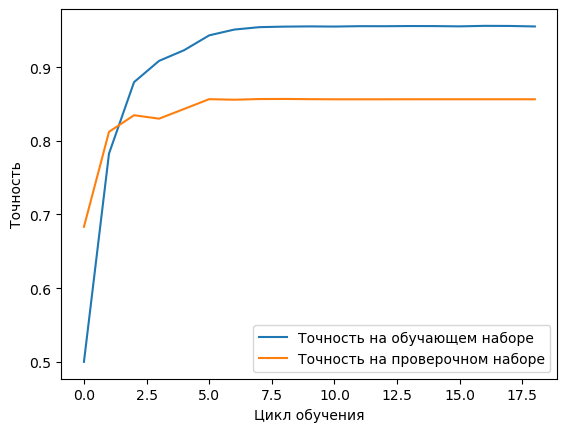

In [16]:
plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(
    history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Цикл обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()
pass;